##### A notebook for exploring diffusion modelling in PyTorch

Text-to-image models like GLIDE, DALL-E 2, Imagen are quite popular these days. Diffusion modelling advancements have contributed largely to this.
In image generation, diffusion modelling is a technique that allows for the generation of high quality images. It is a generative model that is trained to generate images pixel by pixel.


## Diffusion models

Generative models are a class of models that are trained to generate new data samples. They are trained to learn the underlying distribution of the data. This is done by training a model to generate data samples that are similar to the ones in the training set.

Generative models such as Normalizing Flows, GANs or VAEs convert noise from some simple distribution to a data sample. A diffusion model is also a generative model, but it is much simpler. It gradually denoises data starting from pure noise. Fundamentally, Diffusion Models work by destroying training data through the successive addition of Gaussian noise, and then learning to recover the data by reversing this noising process. After training, we can use the Diffusion Model to generate data by simply passing randomly sampled noise through the learned denoising process. Diffusion models are usually slower than VAE, GANs.

In short, Diffusion Models train by corrupting training images with Gaussian Noise in a series of timesteps, and then learning to undo this noising process.

For images, the set-up consists of 2 processes:
* a fixed (or predefined) forward diffusion process $q$ of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise
* a learned reverse denoising diffusion process $p_\theta$, where a neural network is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.

A Diffusion Model is a latent variable model which maps to the latent space using a fixed Markov chain.

Both the forward and reverse process indexed by $(t)$ happen for some number of finite time steps $(T)$ (the DDPM authors use (T=1000)). You start with $(t=0)$ where you sample a real image $(\mathbf{x}_0)$ from your data distribution (let's say an image of a cat from ImageNet), and the forward process samples some noise from a Gaussian distribution at each time step $(t)$, which is added to the image of the previous time step. Given a sufficiently large $(T)$ and a well behaved schedule for adding noise at each time step, you end up with what is called an [isotropic Gaussian distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) at $(t=T)$ via a gradual process.

We define the forward diffusion process $(q(\mathbf{x}_t | \mathbf{x}_{t-1}))$ which adds Gaussian noise at each time step $(t)$, according to a known variance schedule $(0 < \beta_1 < \beta_2 < ... < \beta_T < 1)$ as
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). 
$$

Each new (slightly noiser) image at time step $(t)$ is drawn from a **conditional Gaussian distribution** with $(\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1})$ and $(\sigma^2_t = \beta_t)$, which we can do by sampling $(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}))$ and then setting $(\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon})$. 

The reverse process is Gaussian as well, then any Gaussian distribution is defined by 2 parameters:
* a mean parametrized by $(\mu_\theta)$;
* a variance parametrized by $(\Sigma_\theta)$;

so we can parametrize the process as 
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
where the mean and variance are also conditioned on the noise level $(t)$.


The **variational lower bound** (also called ELBO) can be used to minimize the negative log-likelihood with respect to ground truth data sample $(\mathbf{x}_0)$. The lower bound is defined as follows:
$$
\mathcal{L}(\theta) = \mathbb{E}_{q(\mathbf{x}_T | \mathbf{x}_0)} \left[ \log p_\theta(\mathbf{x}_0 | \mathbf{x}_T) \right] - \mathbb{E}_{q(\mathbf{x}_T | \mathbf{x}_0)} \left[ \log q(\mathbf{x}_T | \mathbf{x}_0) \right]
$$

By construction of the forward $(q)$ process and backward process, each term (except for $(L_0$)) of the loss is actually the **KL divergence between 2 Gaussian distributions** which can be written explicitly as an L2-loss with respect to the means. Thus we need not apply $(q)$ repeatedly in order to sample $(\mathbf{x}_t)$. 
We have that 
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$

with $(\alpha_t := 1 - \beta_t)$ and $(\bar{\alpha}t := \Pi_{s=1}^{t} \alpha_s)$

The final **objective function** $(L_t)$ then looks as follows (for a random time step $(t)$ given $(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}))$ ): 

$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2.$$

The training process is as follows:
* we take a random sample $\mathbf{x}_0$ from the real unknown and possibily complex data distribution $q(\mathbf{x}_0)$
* we sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* we sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ using the nice property defined above
* the neural network is trained to predict this noise based on the corruped image $\mathbf{x}_t$, i.e. noise applied on $\mathbf{x}_0$ based on known schedule $\beta_t$


Resources:

1. https://huggingface.co/blog/annotated-diffusion
2. https://github.com/lucidrains/denoising-diffusion-pytorch
3. https://www.assemblyai.com/blog/minimagen-build-your-own-imagen-text-to-image-model/
4. https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/
5. https://www.youtube.com/watch?v=fbLgFrlTnGU - Ari Seff's explanation of diffusion models
6. https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing - DeepFindr's notebook on diffusion models
7. https://lilianweng.github.io/posts/2021-07-11-diffusion-models/ - Lilian Weng's blog post on diffusion models


In [34]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn, einsum
import torch.nn.functional as F
from torchvision import transforms 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

from torch.utils.data import DataLoader
import math
from inspect import isfunction
from functools import partial
from torch.optim import Adam

In [5]:
def show_images(datset, num_samples=20, cols=4):
    """ to plot images from a dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(datset):
        if i == num_samples:
            break # show only num_samples
        plt.subplot(int(num_samples/cols) + 1, int(cols), int(i + 1)) # plot in a grid
        plt.imshow(img[0])

In [3]:
# loading the Stanford Cars dataset

# use download=True to download the dataset if not already downloaded
data = torchvision.datasets.StanfordCars(root="../data/", download=False)

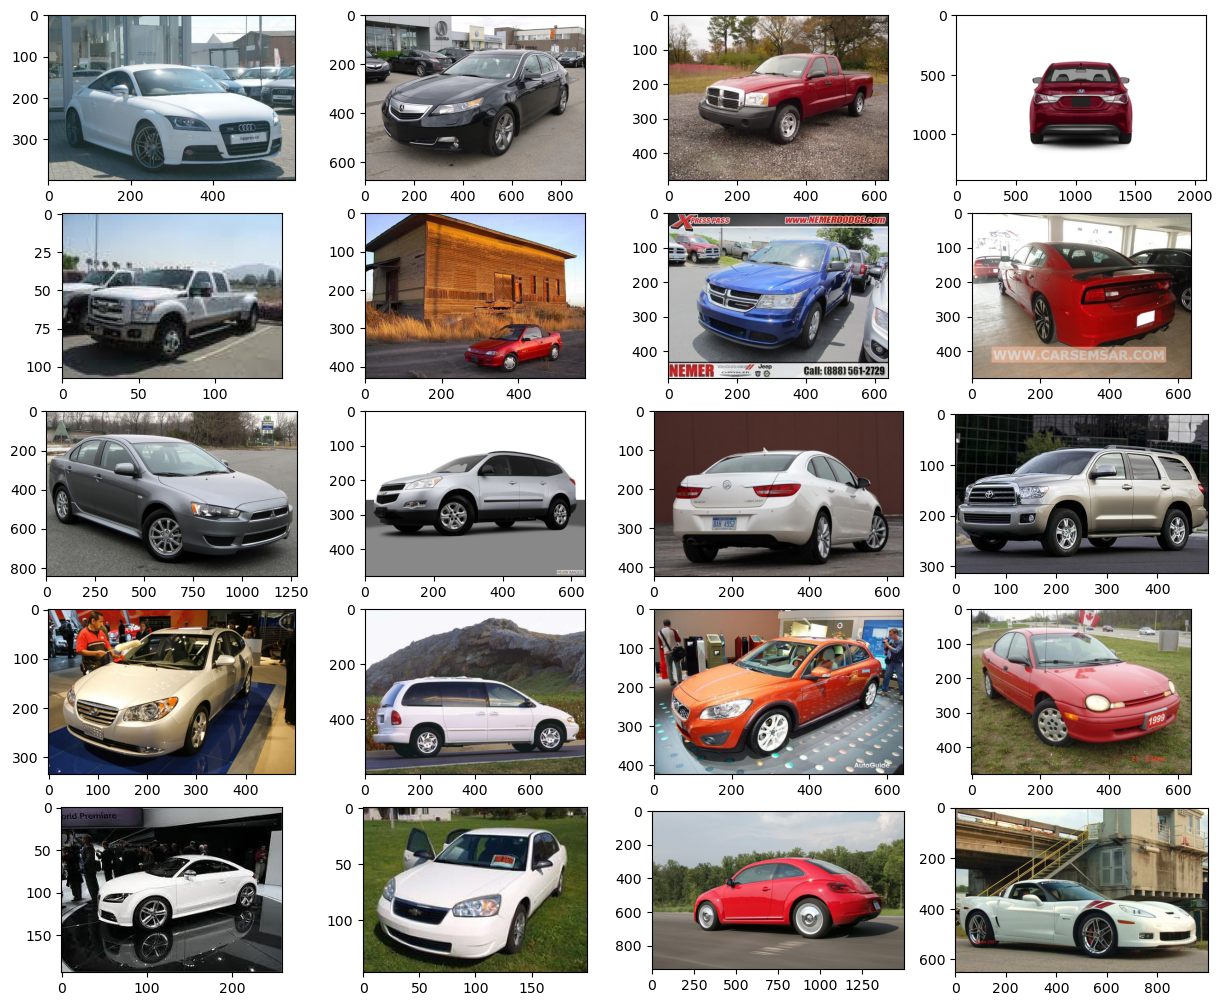

In [6]:
show_images(data)

In [21]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps) # linearly spaced values

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def forward_diffusion(x_0, timesteps, device="cpu"):
    """ 
    Takes an image and a list of timesteps as input and 
    returns the noisy version of it
    """
    x_t = x_0
    for t in timesteps:
        x_t, _ = forward_diffusion_sample(x_t, t, device)
    return x_t    

In [8]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [10]:
IMG_SIZE = 64
BATCH_SIZE = 128

In [19]:
def load_transformed_dataset():
    """ 
    Loads the Stanford Cars dataset and applies the following transformations:
    - Resize to 64x64
    - Random horizontal flip
    - Scale to [0,1]
    - Scale to [-1,1]

    Returns:
        torch.utils.data.ConcatDataset: Concatenated train and test dataset
    """
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root="../data/", download=False, 
                                         transform=data_transform, split='train')

    test = torchvision.datasets.StanfordCars(root="../data/", download=True, 
                                         transform=data_transform, split='test')
                                         
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    """ 
    Takes a tensor image and plots it
    """
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [20]:
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Using downloaded and verified file: ../data/stanford_cars/car_devkit.tgz
Extracting ../data/stanford_cars/car_devkit.tgz to ../data/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting ../data/stanford_cars/cars_test.tgz to ../data/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

/var/folders/5j/d7czpqyn59730dnppn2p0jj00000gn/T/ipykernel_24939/844830087.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


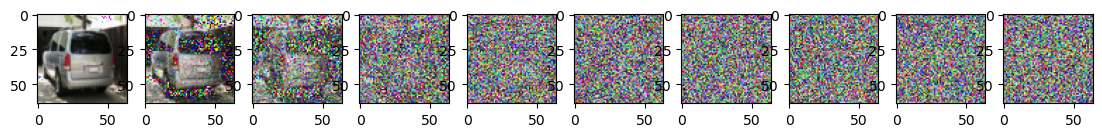

In [26]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t, device="cpu")
    show_tensor_image(image)

In [29]:
# set device to CUDA or MPS if available

device = torch.device("cuda" if torch.cuda.is_available()  else "mps" if torch.has_mps else "cpu")
device

device(type='mps')

In [30]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [31]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [32]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [38]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, int(img_size), int(img_size)), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()            

Epoch 0 | step 000 Loss: 0.7127475142478943 


/var/folders/5j/d7czpqyn59730dnppn2p0jj00000gn/T/ipykernel_24939/3184535124.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize+1))


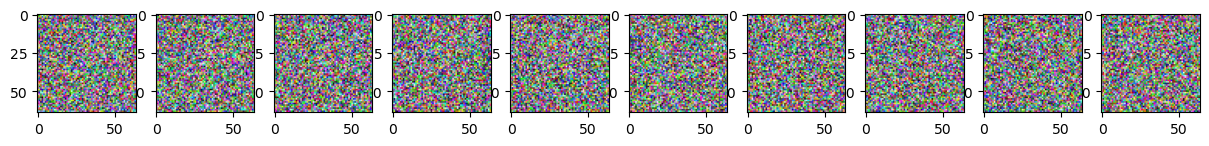

Epoch 5 | step 000 Loss: 0.1725175827741623 


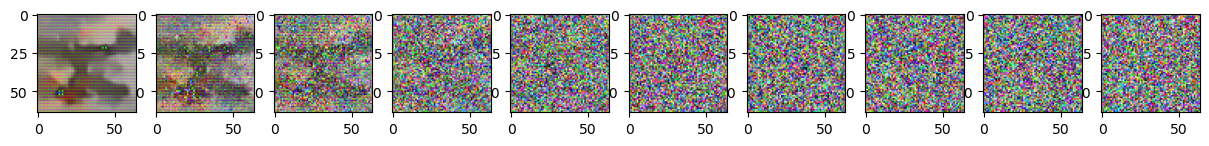

KeyboardInterrupt: 

In [39]:
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

> As my hardware constraints aren't allowing to run the model for long. Have stopped it. However, this excercise gave a better understanding of the diffusion models.